# Parâmetros Gerais para realização do Experimento

In [1]:
numKfolds = 5

idGPU = 0


# Importando bibliotecas para uso com Python

In [2]:
!pip install unidecode

In [3]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import os
import gc
import copy

import re
import string

import numpy as np
import pandas as pd
from math import ceil

import matplotlib.pyplot as plt

from unidecode import unidecode

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import os
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader

import gensim.downloader as api
from gensim.models import KeyedVectors

In [4]:
device = torch.device('cuda:'+str(idGPU) if torch.cuda.is_available() else 'cpu')
write_path = 'model'

# Dataset




In [37]:
dataset = pd.read_csv('./dadosInstFed.csv')

df = pd.DataFrame()
df['x'] = dataset['text']
df['y'] = dataset['polarity']

In [38]:
gc.collect()

56

# Visualizando o Atributo Alvo

In [39]:
df["y"].value_counts()

0    613
1    580
2    259
Name: y, dtype: int64

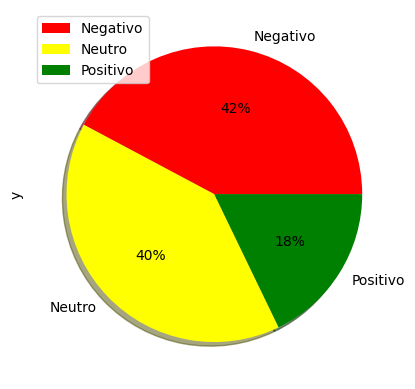

In [40]:
color=['red','yellow', 'green']
explode=[0, 0, 0]
mylabels = ['Negativo', 'Neutro', 'Positivo']

df['y'].value_counts().plot(kind='pie',  autopct='%1.0f%%', labels=mylabels, explode=explode,colors=color, shadow=True)
plt.legend()

# Funções configuradas para o Pré-Processamento de "X"

Função própria para Remover caracteres especiais (acentos e afins)

In [41]:
# Remover caracteres especiais (acentos e afins)

def remove_special_chars(input_text):
    input_text = re.sub(u'[áãâà]', 'a', input_text)
    input_text = re.sub(u'[éèê]', 'e', input_text)
    input_text = re.sub(u'[íì]', 'i', input_text)
    input_text = re.sub(u'[óõôò]', 'o', input_text)
    input_text = re.sub(u'[úùü]', 'u', input_text)
    input_text = re.sub(u'[ç]', 'c', input_text)
    return input_text

Função própria para Remover dígitos

In [42]:
def remove_digits(input_text):
    import re
    return re.sub('\d+', '', input_text)

Função própria para Definir Lista de StopWords

In [43]:
def define_list_stopwords(lg):

  try:
    stopwords_list = stopwords.words(lg)
  except:
    nltk.download('stopwords')
    stopwords_list = stopwords.words(lg)

  return stopwords_list

Função própria para Remover Stopwords

In [44]:
def remove_stopwords(input_text):
    stopwords_list = define_list_stopwords('portuguese')
    words = input_text.split()
    clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 1]
    return " ".join(clean_words)

Função própria para Radicalização (Stemming)

In [45]:
def stemming(input_text):
    porter = PorterStemmer()
    words = input_text.split()
    stemmed_words = [porter.stem(word) for word in words]
    return " ".join(stemmed_words)

Função própria para remover *URL*

In [46]:
def removeURLs(input_text):

  URLless_string = re.sub(r"http\S+", "", str(input_text))
  return (URLless_string)

# Pré-Processamento de "X"

In [47]:
### Função para o pipeline completo do Pré-processamento de "X"

def pipeline_preprocessamento(dfParaProcessar):

  # Lowercase
  dfParaProcessar["x"] = dfParaProcessar["x"].str.lower()

  # Remoção de pontuação e símbolos

  # Tabela de pontuação
  punctuation = string.punctuation
  # Criar tabela de tradução que susbstituirá toda pontuação por um espaço em branco

  trantab = str.maketrans(punctuation, len(punctuation)*' ')
  dfParaProcessar["x"] = dfParaProcessar["x"].apply(lambda x: x.translate(trantab))

  # Remover caracteres especiais (acentos e afins) #### SOMENTE NO TFIDF

  # dfParaProcessar["x"] = dfParaProcessar["x"].apply(lambda x: remove_special_chars(x))

  # Remover caracteres especiais com Unidecode

  # dfParaProcessar["x"] = dfParaProcessar["x"].apply(lambda x: unidecode(x))

  # Remover dígitos

  dfParaProcessar["x"] = dfParaProcessar["x"].apply(lambda x: remove_digits(x))

  # Remover stopwords

  # dfParaProcessar["x"] = dfParaProcessar["x"].apply(lambda x: remove_stopwords(x))

  # Remover URLs

  dfParaProcessar["x"] = dfParaProcessar["x"].apply(lambda x: removeURLs(x))

  # STEMMING COMENTADO PARA NÃO SER REALIZADO

  ####dfParaProcessar["x"] = dfParaProcessar["x"].apply(lambda x: stemming(x))


  return dfParaProcessar

In [48]:
### realizar o Pré-Processamento Completo

df = pipeline_preprocessamento(df)
df

,x,y
0,o instituto federal esta me matando,0
1,o que voce acha de instituto federal é eu acho...,0
2,amigos vou fazer prova no instituto federal no...,1
3,pedro por aaii sou do instituto federal,1
4,amanhã tem instituto federal dnv q vontade de...,0
...,...,...
1447,igcazz eu estudo num instituto federal e tudo...,1
1448,queria ser feliz obstáculo estudo em institu...,0
1449,vai se foder instituto federal da bahia,0
1450,e o gatinho aqui que passou no instituto feder...,2


# Validar as palavras



### Palavras que ocorrem menos de 5 vezes no corpus são retiradas (apenas TDF-IDF, GLOVE e FASTTEXT)



Função própria para identificar palavras com frequência menor que estabelecida

In [49]:
def listarPalavrasMenosFrequentes(xParaProcessar, freqMinimaParaProcessar):
    cnt = xParaProcessar.str.split(expand=True).stack().value_counts()
    lista = []
    for w, c in zip(cnt.index, cnt):
        if(c < freqMinimaParaProcessar):
          lista.append(w)
    return lista


In [50]:
freqMinima = 5
palavrasParaRemover = listarPalavrasMenosFrequentes(df["x"], freqMinima)

Função para remover palavras conforme uma lista definida

In [51]:
def remove_words_in_list(input_text, word_list):

    words = input_text.split()
    clean_words = [word for word in words if (word not in word_list) and len(word) > 1]
    return " ".join(clean_words)

In [52]:
df["x"] = df["x"].apply(lambda x: remove_words_in_list(x, palavrasParaRemover))

# Instanciando o GloVe

In [53]:
def download_and_unzip(url, extract_to='.'):
    http_response = urlopen(url)
    zipfile = ZipFile(BytesIO(http_response.read()))
    zipfile.extractall(path=extract_to)

In [54]:
download_and_unzip("http://143.107.183.175:22980/download.php?file=embeddings/glove/glove_s100.zip")

In [55]:
glove = KeyedVectors.load_word2vec_format('/content/glove_s100.txt')

### Verificação se as palavras estão na base do Glove



Função para fazer a limpeza de palavras que não estão no dicionário

In [56]:
def remove_words_not_in_dic(input_text, dic):
    words = input_text.split()

    clean_words = [word for word in words if (word in dic) and len(word) > 1]
    return " ".join(clean_words)

In [57]:
df["x"] = df["x"].apply(lambda x: remove_words_not_in_dic(x, glove.index_to_key))

In [58]:
df

,x,y
0,instituto federal me matando,0
1,que voce acha de instituto federal eu acho que...,0
2,amigos vou fazer prova no instituto federal no...,1
3,por sou do instituto federal,1
4,amanhã tem instituto federal dnv vontade de me...,0
...,...,...
1447,eu estudo num instituto federal tudo mais mas ...,1
1448,queria ser feliz estudo em instituto federal co,0
1449,vai se foder instituto federal da bahia,0
1450,aqui que passou no instituto federal do ceará ...,2


In [59]:
# remove as sentenças que ficaram vazias
df = df[df.x!='']

### Limita o tamanho das sentenças

In [60]:
def limita_sentenca(sentenca, limite):
  lista_sentenca = sentenca.split(" ")
  if len(lista_sentenca) > limite:
    nova_sentenca = lista_sentenca[:limite]
    nova_sentenca = ' '.join(nova_sentenca)
  else:
    nova_sentenca = ' '.join(lista_sentenca)

  return nova_sentenca

In [61]:
df.x = df.x.apply(lambda k: limita_sentenca(k, 50))

In [62]:
def glove_embedding(sentence, glove_vectors):
  words_list = sentence.split()
  embeddings_list = []
  for word in words_list:
    embeddings_list.append(glove[word])
  return np.concatenate(embeddings_list)

In [63]:
def prepararInputTreinamento(xTreinoParaPreparar):

    xTreinoProcessado = []
    for x in xTreinoParaPreparar:
      x = glove_embedding(x, glove)
      xTreinoProcessado.append(np.pad(x, (0, (100 * 50)-len(x)), 'constant'))

    return np.array(xTreinoProcessado).astype(np.float16)

In [64]:
def prepararInputTeste(xTesteParaPreparar):

    xTesteProcessado = []
    for x in xTesteParaPreparar:
      x = glove_embedding(x, glove)
      xTesteProcessado.append(np.pad(x, (0, (100 * 50)-len(x)), 'constant'))


    return np.array(xTesteProcessado)



# Random Forest

In [65]:
from sklearn.ensemble import RandomForestClassifier

numKfolds = 5
micros = []
macros = []

kf = KFold(n_splits=numKfolds, shuffle=True, random_state=0)

for train_index, test_index in kf.split(df["x"]):
    xTreino, xTeste = df["x"].iloc[train_index], df["x"].iloc[test_index]
    yRealTreino, yRealTeste = df["y"].iloc[train_index], df["y"].iloc[test_index]

    xTreino = prepararInputTreinamento(xTreino)
    xTeste = prepararInputTeste(xTeste)

    forest = RandomForestClassifier(n_estimators = 200, max_features=0.3, oob_score=True, n_jobs=-1, random_state=1, verbose=2)
    forest.fit(xTreino, yRealTreino)

    pred = forest.predict(xTeste)

    print ("Macro-F1: %f" % f1_score(yRealTeste, pred, average='macro'))
    macros.append(f1_score(yRealTeste, pred, average='macro'))
    print ("Micro-F1: %f" % f1_score(yRealTeste, pred, average='micro'))
    micros.append(f1_score(yRealTeste, pred, average='micro'))
    print('\n')


macro_f1 = np.mean(micros)
micro_f1 = np.mean(macros)
std_f1 = np.std(macros)

print('\n\n')
print(f'Média da Macro-F1: {macro_f1:.6f}')
print(f'Média da Micro-F1: {micro_f1:.6f}')
print(f'Desvio padrão da Macro-F1: {std_f1:.6f}')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 200building tree 2 of 200

building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.2s


building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80

[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   44.3s


building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200
building tree 199 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   53.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.1s finished


Macro-F1: 0.494869
Micro-F1: 0.577320


building tree 1 of 200building tree 2 of 200



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.5s


building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80

[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   40.5s


building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200
building tree 199 of 200
building tree 200 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   51.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.1s finished


Macro-F1: 0.476013
Micro-F1: 0.546392


building tree 1 of 200building tree 2 of 200



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.7s


building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81

[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   40.5s


building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200
building tree 199 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   50.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.1s finished


Macro-F1: 0.463920
Micro-F1: 0.562069


building tree 1 of 200building tree 2 of 200



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 3 of 200
building tree 4 of 200
building tree 5 of 200building tree 6 of 200

building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.1s


building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80

[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   40.5s


building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200
building tree 199 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   51.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.1s finished


Macro-F1: 0.528120
Micro-F1: 0.596552


building tree 1 of 200
building tree 2 of 200


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.1s


building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80

[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   37.6s


building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200
building tree 199 of 200
building tree 200 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   48.8s finished


Macro-F1: 0.455757
Micro-F1: 0.544828





Média da Macro-F1: 0.565432
Média da Micro-F1: 0.483736
Desvio padrão da Macro-F1: 0.025803


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.1s finished


# Multinomial Naive Bayes

In [66]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

numKfolds = 5
micros = []
macros = []

scaler = MinMaxScaler()

kf = KFold(n_splits=numKfolds, shuffle=True, random_state=0)

for train_index, test_index in kf.split(df["x"]):
    xTreino, xTeste = df["x"].iloc[train_index], df["x"].iloc[test_index]
    yRealTreino, yRealTeste = df["y"].iloc[train_index], df["y"].iloc[test_index]

    xTreino = prepararInputTreinamento(xTreino)
    xTeste = prepararInputTeste(xTeste)

    xTreino = scaler.fit_transform(xTreino)
    xTeste = scaler.transform(xTeste)

    multinomialNB = MultinomialNB()
    multinomialNB.fit(xTreino, yRealTreino)

    pred = multinomialNB.predict(xTeste)

    print ("Macro-F1: %f" % f1_score(yRealTeste, pred, average='macro'))
    macros.append(f1_score(yRealTeste, pred, average='macro'))
    print ("Micro-F1: %f" % f1_score(yRealTeste, pred, average='micro'))
    micros.append(f1_score(yRealTeste, pred, average='micro'))
    print('\n')


macro_f1 = np.mean(micros)
micro_f1 = np.mean(macros)
std_f1 = np.std(macros)

print('\n\n')
print(f'Média da Macro-F1: {macro_f1:.6f}')
print(f'Média da Micro-F1: {micro_f1:.6f}')
print(f'Desvio padrão da Macro-F1: {std_f1:.6f}')

Macro-F1: 0.408062
Micro-F1: 0.436426


Macro-F1: 0.413997
Micro-F1: 0.446735


Macro-F1: 0.383003
Micro-F1: 0.400000


Macro-F1: 0.405522
Micro-F1: 0.434483


Macro-F1: 0.401663
Micro-F1: 0.427586





Média da Macro-F1: 0.429046
Média da Micro-F1: 0.402449
Desvio padrão da Macro-F1: 0.010517


# KNN

In [67]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier

numKfolds = 5
micros = []
macros = []

kf = KFold(n_splits=numKfolds, shuffle=True, random_state=0)

for train_index, test_index in kf.split(df["x"]):
    xTreino, xTeste = df["x"].iloc[train_index], df["x"].iloc[test_index]
    yRealTreino, yRealTeste = df["y"].iloc[train_index], df["y"].iloc[test_index]

    xTreino = prepararInputTreinamento(xTreino)
    xTeste = prepararInputTeste(xTeste)

    knn = KNeighborsClassifier(n_neighbors=30)
    knn.fit(xTreino, yRealTreino)

    pred = knn.predict(xTeste)

    print ("Macro-F1: %f" % f1_score(yRealTeste, pred, average='macro'))
    macros.append(f1_score(yRealTeste, pred, average='macro'))
    print ("Micro-F1: %f" % f1_score(yRealTeste, pred, average='micro'))
    micros.append(f1_score(yRealTeste, pred, average='micro'))
    print('\n')


macro_f1 = np.mean(micros)
micro_f1 = np.mean(macros)
std_f1 = np.std(macros)

print('\n\n')
print(f'Média da Macro-F1: {macro_f1:.6f}')
print(f'Média da Micro-F1: {micro_f1:.6f}')
print(f'Desvio padrão da Macro-F1: {std_f1:.6f}')

Macro-F1: 0.335888
Micro-F1: 0.446735


Macro-F1: 0.352831
Micro-F1: 0.477663


Macro-F1: 0.309142
Micro-F1: 0.427586


Macro-F1: 0.376924
Micro-F1: 0.510345


Macro-F1: 0.323205
Micro-F1: 0.448276





Média da Macro-F1: 0.462121
Média da Micro-F1: 0.339598
Desvio padrão da Macro-F1: 0.023573


# SVM

In [68]:
from sklearn.svm import LinearSVC

from sklearn.ensemble import RandomForestClassifier

numKfolds = 5
micros = []
macros = []

kf = KFold(n_splits=numKfolds, shuffle=True, random_state=0)

for train_index, test_index in kf.split(df["x"]):
    xTreino, xTeste = df["x"].iloc[train_index], df["x"].iloc[test_index]
    yRealTreino, yRealTeste = df["y"].iloc[train_index], df["y"].iloc[test_index]

    xTreino = prepararInputTreinamento(xTreino)
    xTeste = prepararInputTeste(xTeste)

    svm = LinearSVC(C=1)
    svm.fit(xTreino, yRealTreino)

    pred = svm.predict(xTeste)

    print ("Macro-F1: %f" % f1_score(yRealTeste, pred, average='macro'))
    macros.append(f1_score(yRealTeste, pred, average='macro'))
    print ("Micro-F1: %f" % f1_score(yRealTeste, pred, average='micro'))
    micros.append(f1_score(yRealTeste, pred, average='micro'))
    print('\n')


macro_f1 = np.mean(micros)
micro_f1 = np.mean(macros)
std_f1 = np.std(macros)

print('\n\n')
print(f'Média da Macro-F1: {macro_f1:.6f}')
print(f'Média da Micro-F1: {micro_f1:.6f}')
print(f'Desvio padrão da Macro-F1: {std_f1:.6f}')

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Macro-F1: 0.502199
Micro-F1: 0.529210




/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Macro-F1: 0.481935
Micro-F1: 0.505155




/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Macro-F1: 0.470862
Micro-F1: 0.506897




/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Macro-F1: 0.497776
Micro-F1: 0.524138


Macro-F1: 0.474356
Micro-F1: 0.510345





Média da Macro-F1: 0.515149
Média da Micro-F1: 0.485426
Desvio padrão da Macro-F1: 0.012496


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
